This notebook works out the basic components that are required to implement the Fourier method discussed in Samsing (2015).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import os
%matplotlib inline

In [2]:
seedn = 2
np.random.seed(seedn)

# make a fake kepler quarter, in relative flux units, with gaussian
# errors, and transits injected.
mintime = 5+np.random.rand()
maxtime = 94+np.random.rand()
exp_time_minutes = 29.423259                                                                                                                                                                                     
exp_time_days = exp_time_minutes / (24.*60)  
times = np.arange(mintime, maxtime, exp_time_days)

# drop 5% of data points (e.g. quality flags).
n_to_drop = int(len(times)/20)
todrop = np.random.random_integers(0, len(times), size=n_to_drop)
times = np.delete(times, todrop)

# be nice with the noise...
flux_baseline = np.ones_like(times)
flux_noise = np.random.normal(loc=0.0, scale=0.001, size=np.size(times))

params = batman.TransitParams()
P_b = 10+np.random.rand()
t0 = np.random.uniform(min(times), min(times)+P_b)
params.t0 = t0
params.per = P_b                     #orbital period
params.rp = (0.01)**(1/2.)           #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients
params.limb_dark = "quadratic"       #limb darkening model

ss_factor = 10
m = batman.TransitModel(params,
                        times,
                        supersample_factor = ss_factor,
                        exp_time = exp_time_days)
flux_to_inj = m.light_curve(params) - 1.

fluxs = flux_baseline + flux_noise + flux_to_inj
fluxs = (fluxs - np.median(fluxs)) / np.median(fluxs)
# get systematically wonkily reported errors
errs = flux_noise * (1+0.02*np.random.rand(np.size(flux_noise)))

τ_i = t0
N_transits = int(np.floor((max(times) - min(times))/P_b))
τ_f = t0 + N_transits*P_b
T_w = τ_f - τ_i

times_cut = times[(times < τ_f) & (times > τ_i)]
fluxs_cut = fluxs[(times < τ_f) & (times > τ_i)]
errs_cut = errs[(times < τ_f) & (times > τ_i)]

# Now that we have the times, fluxs, and errs, we want to separate the signal & noise following `170314_derivn_Samsing_method.pdf`.
# Note, per the plots way below, that the actual times at the data will in general not fall directly on the time of first transit, $\tau_i$,
#or that of the last transit, $\tau_f$.
# It's then necessary to _add in_ two (time, flux, err) points into the data, corresponding to these times and interpolated
#signals near them.
# Do so by fitting local quadratic to data points around 0.05 days to 
# allow for 2 data points on either side 
times_near_τi = times[(times < τ_i+0.05) & (times > τ_i-0.05)]
fluxs_near_τi = fluxs[(times < τ_i+0.05) & (times > τ_i-0.05)]
errs_near_τi = errs[(times < τ_i+0.05) & (times > τ_i-0.05)]
times_near_τf = times[(times < τ_f+0.05) & (times > τ_f-0.05)]
fluxs_near_τf = fluxs[(times < τ_f+0.05) & (times > τ_f-0.05)]
errs_near_τf = errs[(times < τ_f+0.05) & (times > τ_f-0.05)]

from scipy.interpolate import interp1d

f_near_τi = interp1d(times_near_τi, fluxs_near_τi, kind='quadratic')
f_near_τf = interp1d(times_near_τf, fluxs_near_τf, kind='quadratic')

# fine times are just for subsequent plotting and checking
finetimes_τi = np.concatenate((
               np.arange(τ_i, np.max(times_near_τi), exp_time_days/2),
               np.arange(np.min(times_near_τi), τ_i, exp_time_days/2)
               ))
finetimes_τf = np.concatenate((
               np.arange(τ_f, np.max(times_near_τf), exp_time_days/2),
               np.arange(np.min(times_near_τf), τ_f, exp_time_days/2)
               ))
fluxs_τi_interp = f_near_τi(finetimes_τi)
fluxs_τf_interp = f_near_τf(finetimes_τf)

# these are the interpolated values that will be used
flux_interp_at_τi = f_near_τi(τ_i)
flux_interp_at_τf = f_near_τf(τ_f)

fluxs_sel = np.append(
            np.insert(fluxs_cut, 0, flux_interp_at_τi),
            flux_interp_at_τf)
times_sel = np.append(
            np.insert(times_cut, 0, τ_i),
            τ_f)
# fudge the errors for the first and last inserted selected data points
errs_sel = np.append(
            np.insert(errs_cut, 0, errs_cut[0]),
            errs_cut[-1])

# With preprocessing done, we are ready for the Samsing (2015) method
N = len(fluxs_sel) # number of data points

# Construct Samsing (2015) C, S and T matrices.
# Row index is times. Column index is frequencies (up to the Nyquist frequency)
C = np.zeros((N, int(np.floor(N/2))))
S = np.zeros((N, int(np.floor(N/2))))

# index-wise implementation: slow but instructive
#for i, t_i in enumerate(times_sel): # rows
#    for j, n_j in enumerate(range(1, int(np.floor(N/2)))): # cols
#        C[i,j] = np.cos(2 * np.pi * n_j * t_i / T_w)
#        S[i,j] = np.sin(2 * np.pi * n_j * t_i / T_w)

# vectorized implementation: fast and trickier
print('constructing cosine and sine matrices')
# n = {1, 2, 3, ..., floor(N/2)}
n = np.array(range(1, int(np.floor(N/2)+1)))
C = np.cos(2 * np.pi * np.outer(times_sel-τ_i, n) / T_w)
S = np.sin(2 * np.pi * np.outer(times_sel-τ_i, n) / T_w)

T = np.concatenate((C,S), axis=1)

# Solve for the least squares coefficients. Compute Fourier approxn.
from numpy.linalg import inv
print('beginning least squares soln for coeffs')
R = inv(T.T @ T) @ T.T @ fluxs_sel
print('finished inversion for least squares coeffs')
I_approx = T @ R

# split joined coefficient array into odd and even components
a = R[:int(np.floor(N/2))]
b = R[int(np.floor(N/2)):]

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 4336 + 1) instead


constructing cosine and sine matrices
beginning least squares soln for coeffs
finished inversion for least squares coeffs


In [5]:
# N_0: number of planet orbits in data window
N_0 = N_transits - 1
# m = {1, 2, 3, ..., floor(N/(2*N_0))}
m = np.array( range(1, int(np.floor(N/(2*N_0)))+1) )
# Get the even and odd components of the reconstructed signal!
# Initialize first:
a_Signal = np.zeros_like(m)
b_Signal = np.zeros_like(m)

for ind, this_m in enumerate(m):
    
    selind = this_m*N_0 - 1 # -1 because python is 0-based
    
    # linearly interpolate over isolated peaks
    if selind < len(a) -1:
        a_Signal[ind] = a[selind]  - (a[selind-1] + a[selind+1])/2.
        b_Signal[ind] = b[selind]  - (b[selind-1] + b[selind+1])/2.
        
    # edge case: just subtract the previous one 
    elif selind == len(a) - 1:
        a_Signal[ind] = a[selind] - a[selind-1]
        b_Signal[ind] = b[selind] - b[selind-1]

#??? not clear here :/
I_Signal = a_Signal @ np.cos(2 * np.pi * np.outer(m, times_sel) / P_b) + \
           b_Signal @ np.sin(2* np.pi * np.outer(m, times_sel) / P_b)

#I_Signal = a_Signal @ np.cos(2 * np.pi * np.outer(m, times_sel-τ_i) / T_w) + \
#           b_Signal @ np.sin(2* np.pi * np.outer(m, times_sel-τ_i) / T_w)

#I_Signal = a_Signal @ np.cos(2 * np.pi * np.outer(m, times_sel-τ_i) / τ_i) + \
#           b_Signal @ np.sin(2* np.pi * np.outer(m, times_sel-τ_i) / τ_i)

In [6]:
print('number of data points', N)
print('number of transits', N_transits)
print('number of orbital periods', N_0)
print('number of selected times (same as N?)', len(times_sel))
print('shape of cosine matrix (rows: times, cols: freqs)', np.shape(C))
print('shape of joined [a,b] coefficient matrix', np.shape(R))
print('shape of joined [cosine, sine] matrix', np.shape(T))
print('shape of split `a` coefficient matrix', np.shape(a))
print('shape of \"signal\" Fourier coeffs', np.shape(a_Signal))
print('shape of reconstructed signal', np.shape(I_Signal))
print('floor(N/2N_0)', int(np.floor(N/(2*N_0))))

number of data points 4019
number of transits 8
number of orbital periods 7
number of selected times (same as N?) 4019
shape of cosine matrix (rows: times, cols: freqs) (4019, 2009)
shape of joined [a,b] coefficient matrix (4018,)
shape of joined [cosine, sine] matrix (4019, 4018)
shape of split `a` coefficient matrix (2009,)
shape of "signal" Fourier coeffs (287,)
shape of reconstructed signal (4019,)
floor(N/2N_0) 287


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


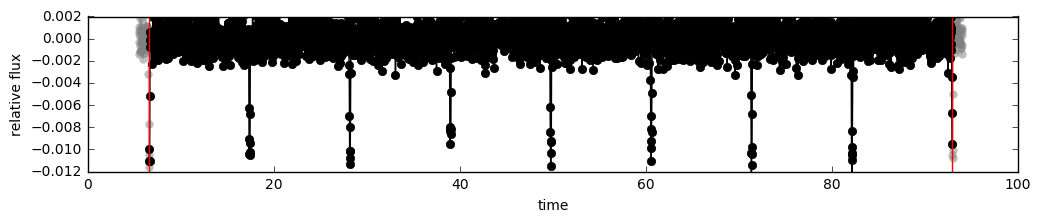

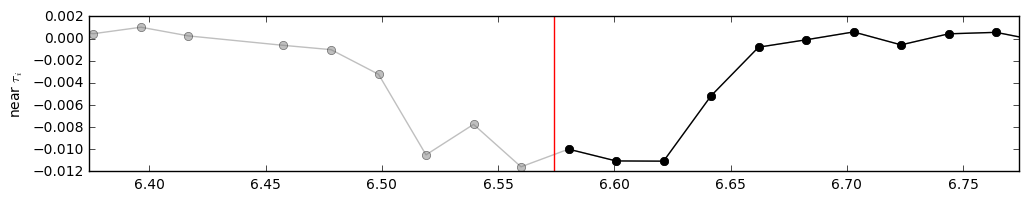

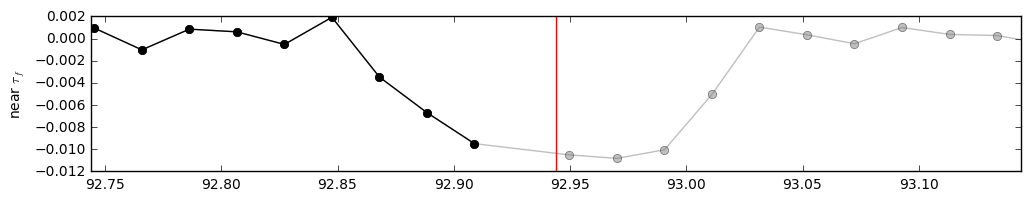

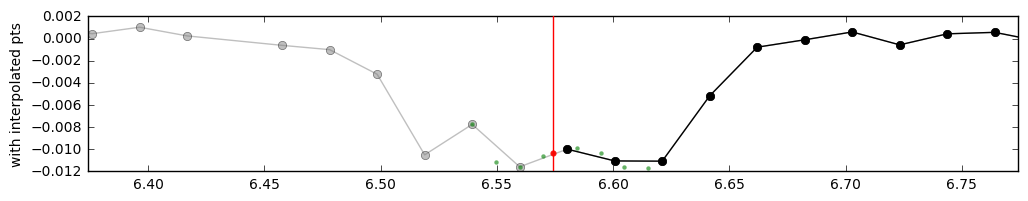

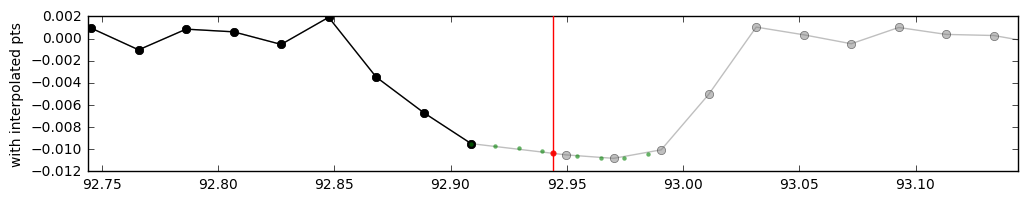

In [7]:
##########
# MAIN TIMESERIES
f, ax = plt.subplots(figsize=(12,2))
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', marker='o', zorder=1)
ax.plot(times, fluxs, c='gray', alpha=0.5, linestyle='-', marker='o', markeredgewidth=0, zorder=0)
ax.vlines([τ_i, τ_f], -1, 1, color='red', zorder=2)
ax.set_xlabel("time")
ax.set_ylabel("relative flux")
ax.set_ylim([-0.012, 0.002])
f.show()

# AT LOCAL INITIAL AND FINAL TRANSIT TIMES
f, ax = plt.subplots(figsize=(12,2))
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', marker='o', zorder=1)
ax.plot(times, fluxs, c='gray', alpha=0.5, linestyle='-', marker='o', zorder=0)
ax.vlines([τ_i, τ_f], -1, 1, color='red', zorder=2)
ax.set_ylabel(r"near $\tau_i$")
ax.set_ylim([-0.012, 0.002])
ax.set_xlim([τ_i-0.2,τ_i+0.2])
f.show()

f, ax = plt.subplots(figsize=(12,2))
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', marker='o', zorder=1)
ax.plot(times, fluxs, c='gray', alpha=0.5, linestyle='-', marker='o', zorder=0)
ax.vlines([τ_i, τ_f], -1, 1, color='red', zorder=2)
ax.set_ylabel(r"near $\tau_f$")
ax.set_ylim([-0.012, 0.002])
ax.set_xlim([τ_f-0.2,τ_f+0.2])
f.show()

# CHECKING INTERPOLATION
f, ax = plt.subplots(figsize=(12,2))
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', marker='o', zorder=1)
ax.plot(times, fluxs, c='gray', alpha=0.5, linestyle='-', marker='o', zorder=0)
ax.scatter(finetimes_τi, fluxs_τi_interp, c='green', linewidth=0, marker='o', s=10, zorder=2, alpha=0.6)
ax.scatter(τ_i, flux_interp_at_τi, c='red', linewidth=0, marker='o', s=20, zorder=5, alpha=0.9)
ax.vlines([τ_i, τ_f], -1, 1, color='red', zorder=3)
ax.set_ylabel("with interpolated pts")
ax.set_ylim([-0.012, 0.002])
ax.set_xlim([τ_i-0.2,τ_i+0.2])
f.show()

f, ax = plt.subplots(figsize=(12,2))
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', marker='o', zorder=1)
ax.plot(times, fluxs, c='gray', alpha=0.5, linestyle='-', marker='o', zorder=0)
ax.scatter(finetimes_τf, fluxs_τf_interp, c='green', linewidth=0, marker='o', s=10, zorder=2, alpha=0.6)
ax.scatter(τ_f, flux_interp_at_τf, c='red', linewidth=0, marker='o', s=20, zorder=5, alpha=0.9)
ax.vlines([τ_i, τ_f], -1, 1, color='red', zorder=3)
ax.set_ylabel("with interpolated pts")
ax.set_ylim([-0.012, 0.002])
ax.set_xlim([τ_f-0.2,τ_f+0.2])
f.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


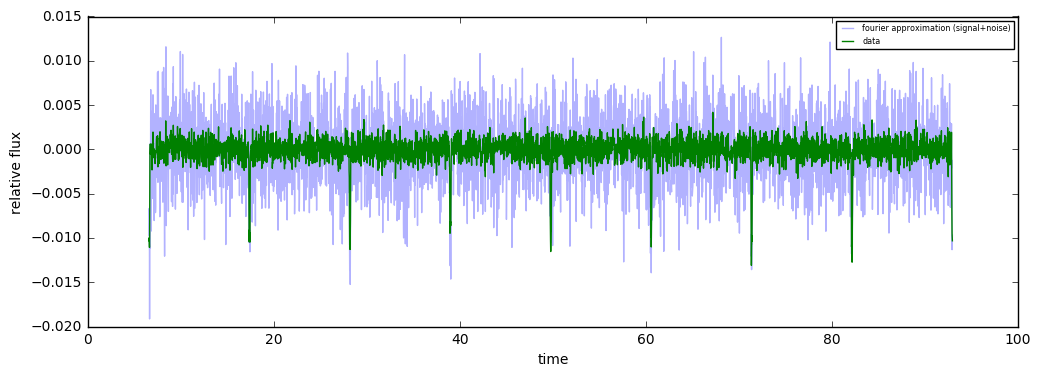

In [8]:
# Check that the overall approximation at least has the signal in it.
f, ax = plt.subplots(figsize=(12,4))
ax.plot(times_sel, I_approx, alpha=0.3, label='fourier approximation (signal+noise)')
ax.plot(times_sel, fluxs_sel, label='data')
ax.legend(fontsize='xx-small')
ax.set(xlabel='time', ylabel='relative flux')
f.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


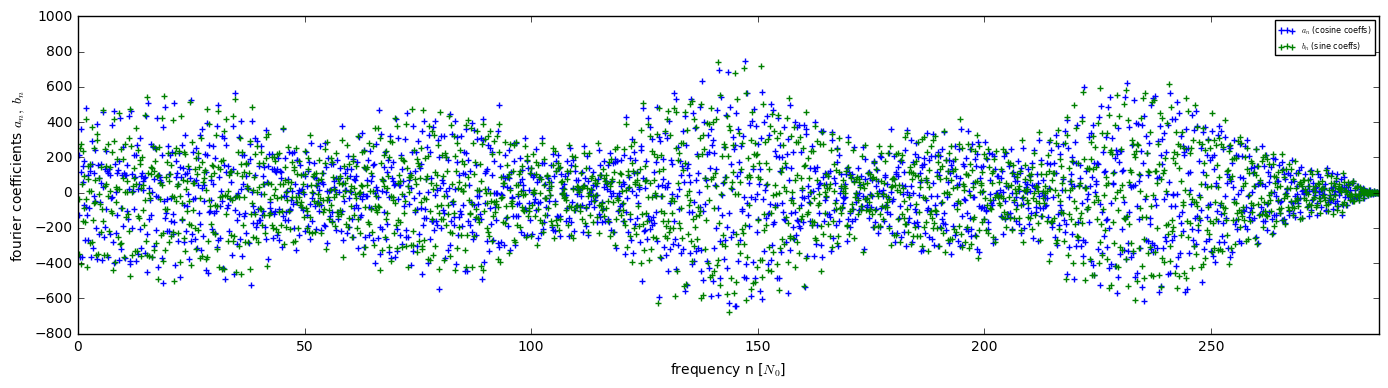

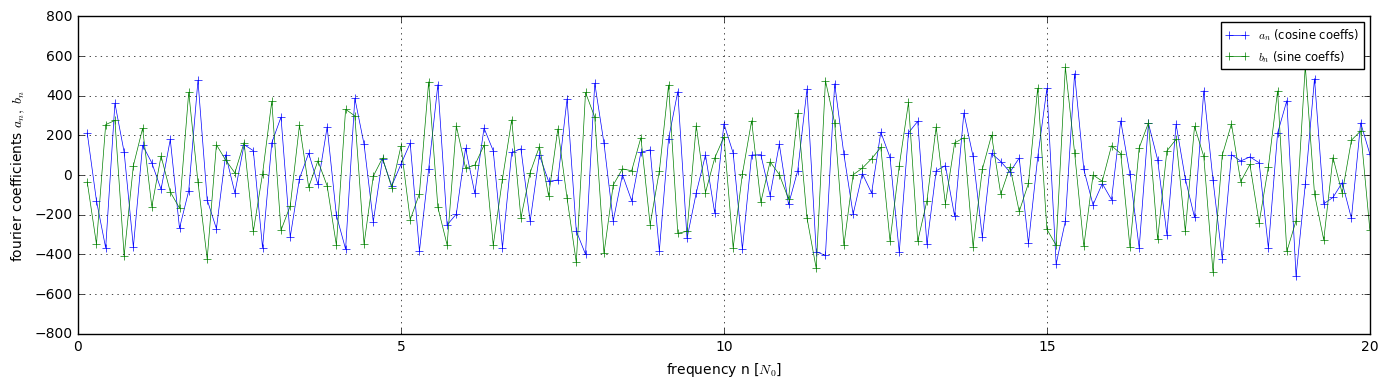

In [9]:
# First look at full fourier range
f, ax = plt.subplots(figsize=(14,4))
ax.scatter(n/N_0, a, c='blue', lw=1, marker='+', label='$a_n$ (cosine coeffs)')
ax.scatter(n/N_0, b, c='green', lw=1, marker='+', label='$b_n$ (sine coeffs)')
ax.set(xlabel='frequency n [$N_0$]',
       ylabel='fourier coefficients $a_n,\ b_n$',
       xlim=[0, max(n/N_0)])
ax.legend(fontsize='xx-small')
f.tight_layout()
f.show()

# Then look at lowest frequencies, like Samsing (2015)
f, ax = plt.subplots(figsize=(14,4))
ax.plot(n/N_0, a, c='blue', lw=0.5, marker='+', label='$a_n$ (cosine coeffs)')
ax.plot(n/N_0, b, c='green', lw=0.5, marker='+', label='$b_n$ (sine coeffs)')
ax.set(xlabel='frequency n [$N_0$]',
       ylabel='fourier coefficients $a_n,\ b_n$',
       xlim=[0, 20])
ax.grid(which='both')
ax.legend(fontsize='small')
f.tight_layout()
f.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


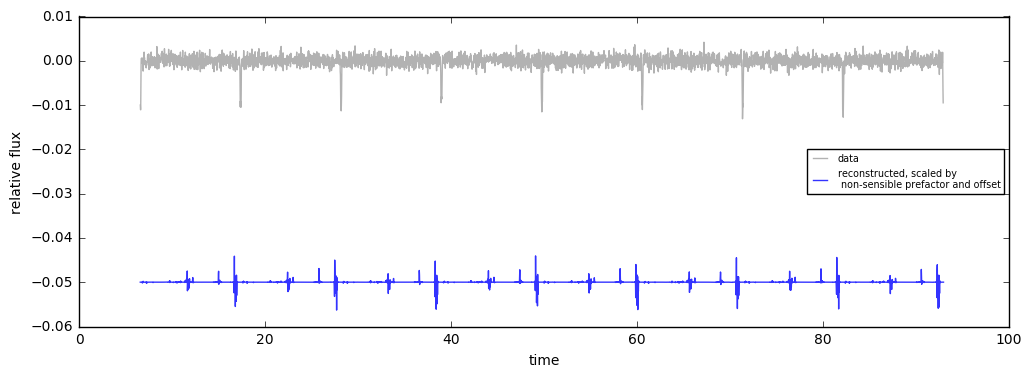

In [10]:
# Check whether the reconstructed signal is any good.
f, ax = plt.subplots(figsize=(12,4))
#ax.plot(times, fluxs, c='gray', alpha=0.2, linestyle='-', marker='o', zorder=0)
ax.plot(times_cut, fluxs_cut, c='black', linestyle='-', zorder=1, alpha=0.3, label='data')
if seedn == 2:
    pref = 1e-7
else:
    pref = 1e-6
ax.plot(times_sel, -0.05 + I_Signal*pref, c='blue', linestyle='-', marker=None, zorder=3, alpha=0.8, label='reconstructed, scaled by\n non-sensible prefactor and offset')
ax.set_xlabel("time")
ax.set_ylabel("relative flux")
ax.legend(loc='best',fontsize='x-small')
f.show()